In [1]:
# earth engine things
import ee
import geemap
ee.Authenticate()
ee.Initialize()

## Province Level

### Forested area remaining

In [6]:
import pandas as pd

# load Hansen dataset
dataset = ee.Image('UMD/hansen/global_forest_change_2023_v1_11')

# bands
tree_cover = dataset.select('treecover2000')
loss_year = dataset.select('lossyear')

# load Zambia province boundaries
# level 0: country level
# level 1: province level
provinces = ee.FeatureCollection('FAO/GAUL/2015/level1') \
    .filter(ee.Filter.eq('ADM0_NAME', 'Zambia'))

# define forest threshold
forest_2000 = tree_cover.gte(30)

# baseline forest area per province
def compute_baseline(feature):
    name = feature.get('ADM1_NAME')
    stats = forest_2000.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = feature.geometry(),
        scale = 30,
        maxPixels = 1e13
    )
    area_m2 = stats.get('treecover2000')
    return feature.set({'province': name, 'baseline_m2': area_m2})

baseline = provinces.map(compute_baseline).getInfo()

# store baseline forest area per province
baseline_dict = {
    f['properties']['province']: f['properties']['baseline_m2'] or 0 for f in baseline['features']
}

previous_forest_m2 = {p: baseline_dict.get(p, 0) for p in baseline_dict}
cumulative_loss_m2 = {}

# create empty list to store data
results = []

for year in range(2001, 2023):
    year_offset = year - 2000
    loss_in_year = loss_year.eq(year_offset)
    # mask to forested pixels in loss year
    loss_year_forest = loss_in_year.And(forest_2000)
    # convert to area (square meters)
    loss_area = loss_year_forest.multiply(ee.Image.pixelArea())
    # get total loss area for each province
    def compute_loss(feature):
        # province names
        name = feature.get('ADM1_NAME')
        stats = loss_area.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = feature.geometry(),
            scale = 30,
            maxPixels = 1e13
        )
       
        area_m2 = stats.values().get(0)
        return feature.set({
            'province': name, 
            'year': year,
            'loss_m2': area_m2
        })
        
    yearly_results = provinces.map(compute_loss).getInfo()

    # extract data to Python
    for feat in yearly_results['features']:
        properties = feat['properties']
        province = properties['province']
        loss_m2 = properties['loss_m2'] or 0

        previous_m2 = previous_forest_m2.get(province, 0)
        cumulative_loss_m2[province] = cumulative_loss_m2.get(province, 0) + loss_m2

        # compute remaining forest cover
        remaining_m2 = previous_m2 - loss_m2
        remaining_ha = max(remaining_m2 / 10000, 0)

        annual_percent_loss = (loss_m2 / previous_m2 * 100) if previous_m2 > 0 else 0

        previous_forest_m2[province] = remaining_m2

        results.append({
            'province': province,
            'year': year,
            'forest_cover_ha': remaining_ha,
            'loss_m2': loss_m2, 
            'percent_loss_annual': annual_percent_loss
        })

df_cover = pd.DataFrame(results)
#df_cover.to_csv('province_forest_cover.csv', index=False)    

### Plot

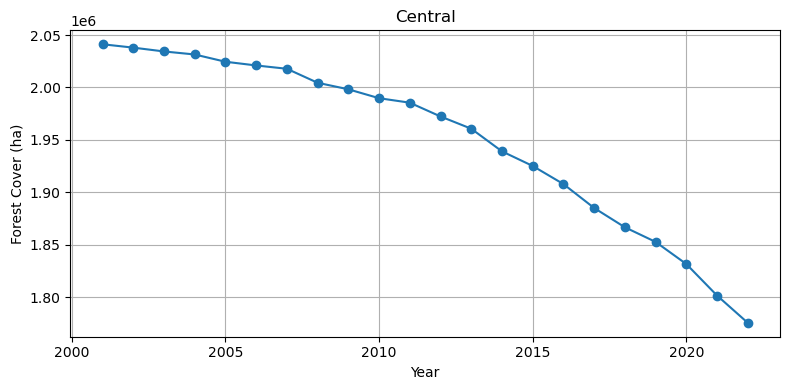

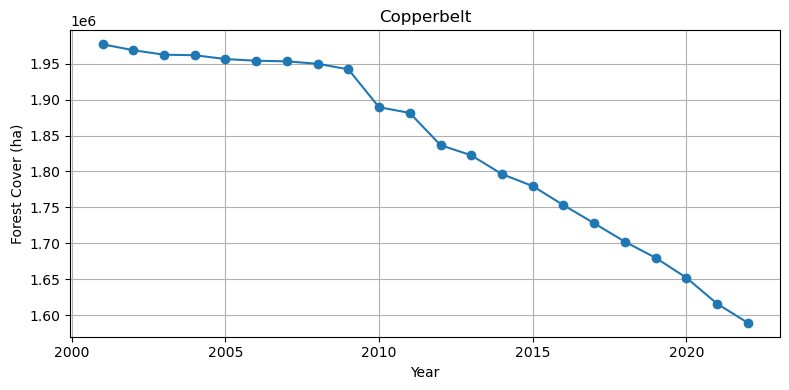

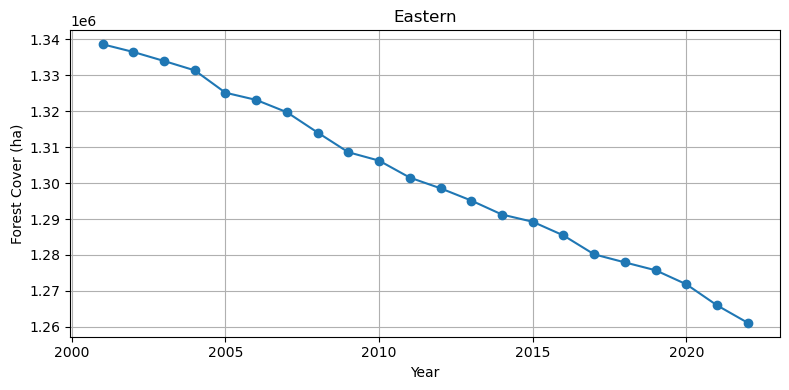

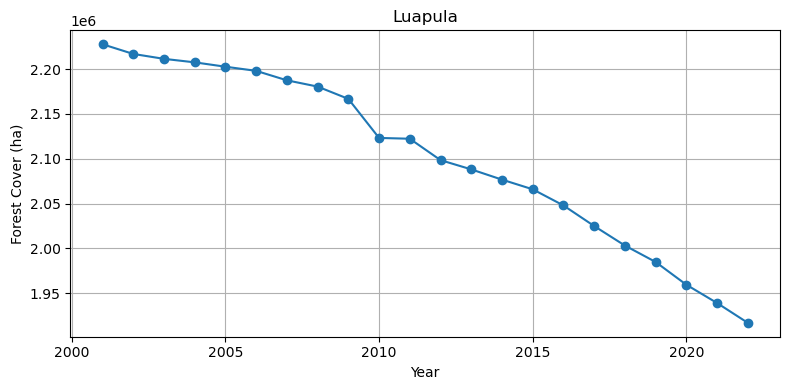

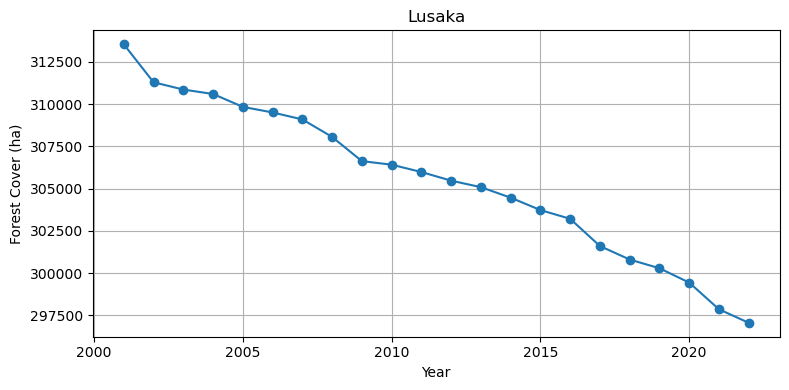

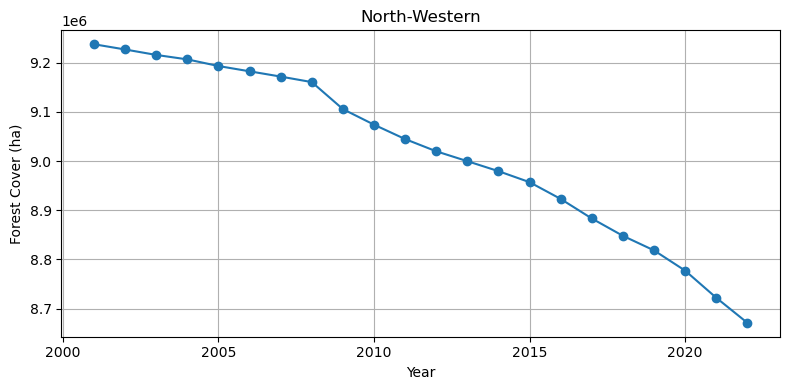

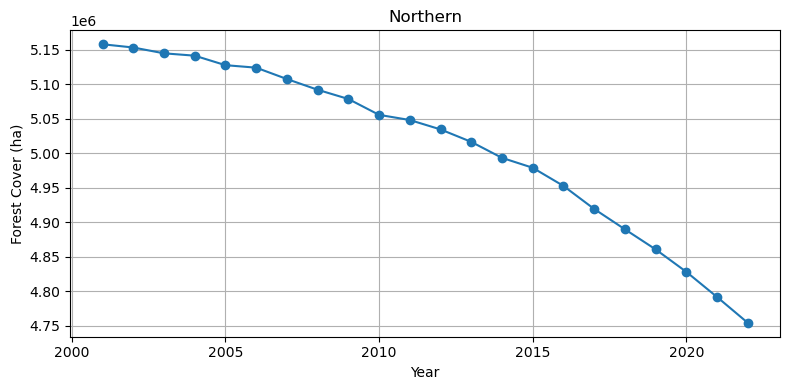

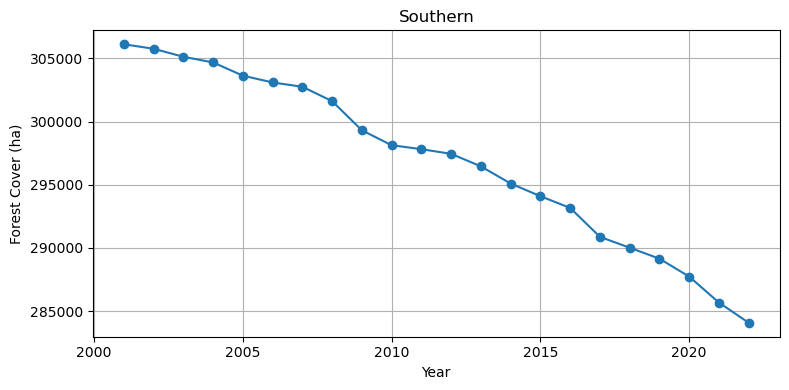

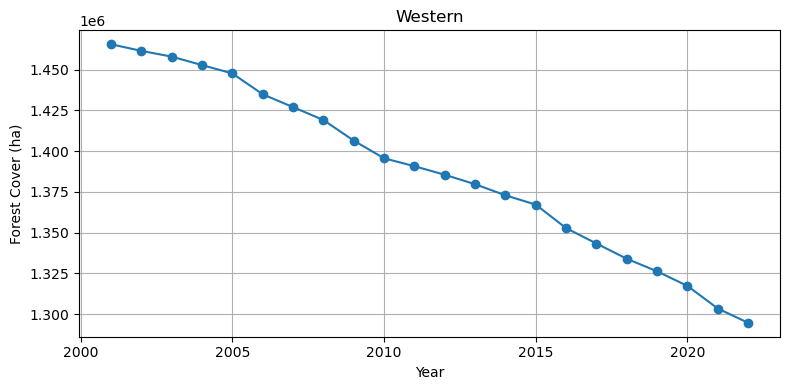

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./province_forest_cover.csv')
provinces = df['province'].unique()

for province in provinces:
    subset = df[df['province'] == province]
    plt.figure(figsize=(8,4))
    plt.plot(subset['year'], subset['forest_cover_ha'], marker='o')
    plt.title(f'{province}')
    plt.xlabel('Year')
    plt.ylabel('Forest Cover (ha)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

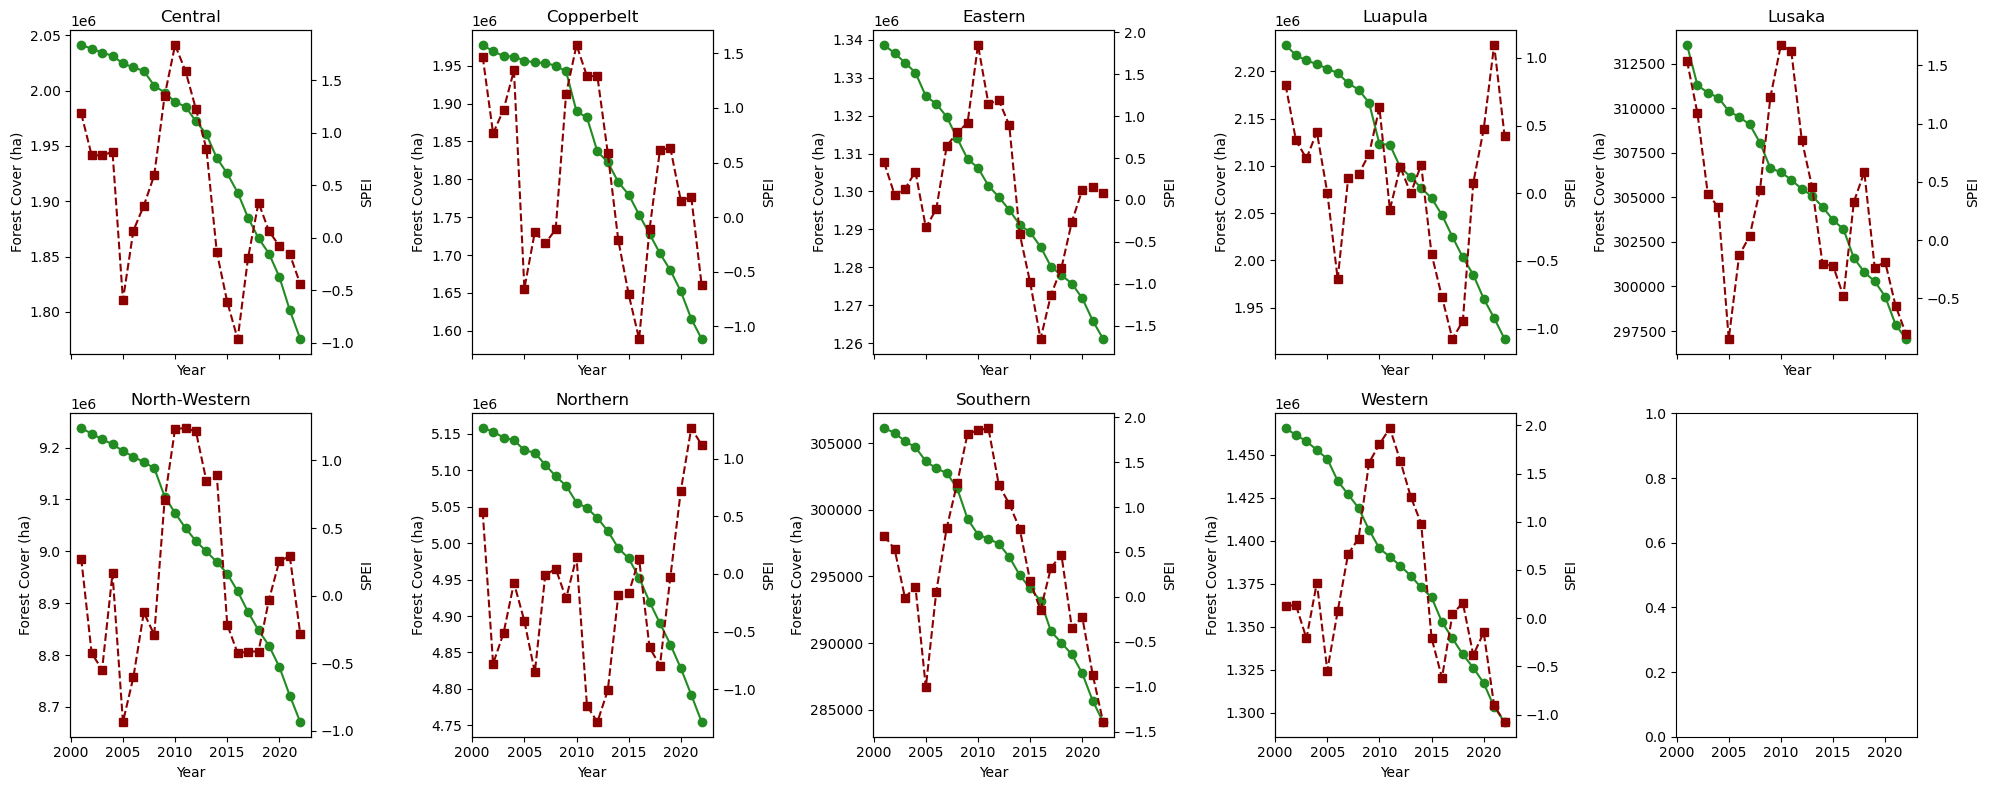

In [8]:
import pandas as pd
spei = pd.read_csv('./province_spei_average.csv', parse_dates=['date'])

# convert spei data to long format
spei_long = spei.melt(id_vars='date', var_name='province', value_name='spei')
spei_long['year'] = spei_long['date'].dt.year
spei_long['spei'] = spei_long['spei'].interpolate()

# aggregate SPEI to annual mean
spei_annual = spei_long.groupby(['province', 'year'])['spei'].mean().reset_index()

# merge dataframes
merged_df = pd.merge(spei_annual, df, on=['province', 'year'])

# get unique province names
provinces = merged_df['province'].unique()

# create panel plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharex=True)
axes = axes.flatten()

for i, province in enumerate(provinces[:10]):
    ax1 = axes[i]
    subset = merged_df[merged_df['province'] == province].sort_values('year')
    ax1.plot(subset['year'], subset['forest_cover_ha'], color='forestgreen', marker='o', label='Forest Cover')
    ax1.set_ylabel('Forest Cover (ha)')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(subset['year'], subset['spei'], color='darkred', marker='s', linestyle='--', label='SPEI')
    ax2.set_ylabel('SPEI')
    ax2.tick_params(axis='y')
    ax1.set_title(province)
    ax1.set_xlabel('Year')

plt.tight_layout()
plt.show()

## District Level

In [7]:
# level 2: district level
districts = ee.FeatureCollection('FAO/GAUL/2015/level2') \
    .filter(ee.Filter.eq('ADM0_NAME', 'Zambia'))

# baseline forest area per province
def compute_baseline(feature):
    name = feature.get('ADM2_NAME')
    stats = forest_2000.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = feature.geometry(),
        scale = 30,
        maxPixels = 1e13
    )
    area_m2 = stats.get('treecover2000')
    return feature.set({'district': name, 'baseline_m2': area_m2})

baseline = districts.map(compute_baseline).getInfo()

# store baseline forest area per district
baseline_dict = {
    f['properties']['district']: f['properties']['baseline_m2'] or 0 for f in baseline['features']
}

# initialize previous forest area tracker
previous_forest_m2 = {d: baseline_dict.get(d, 0) for d in baseline_dict}
cumulative_loss_m2 = {}

# create empty list to store data
results = []

for year in range(2001, 2023):
    year_offset = year - 2000
    loss_in_year = loss_year.eq(year_offset)
    # mask to forested pixels in loss year
    loss_year_forest = loss_in_year.And(forest_2000)
    # convert to area (square meters)
    loss_area = loss_year_forest.multiply(ee.Image.pixelArea())
    # get total loss area for each district
    def compute_loss(feature):
        # district names
        name = feature.get('ADM2_NAME')
        stats = loss_area.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = feature.geometry(),
            scale = 30,
            maxPixels = 1e13
        )
       
        area_m2 = stats.get('lossyear')
        return feature.set({
            'district': name, 
            'year': year,
            'loss_m2': area_m2
        })
        
    yearly_results = districts.map(compute_loss).getInfo()

    # extract data to Python
    for feat in yearly_results['features']:
        properties = feat['properties']
        district = properties['district']
        loss_m2 = properties['loss_m2'] or 0
        previous_m2 = previous_forest_m2.get(district, 0)
        cumulative_loss_m2[district] = cumulative_loss_m2.get(district, 0) + loss_m2
        remaining_m2 = previous_m2 - loss_m2
        remaining_ha = max(remaining_m2 / 10000, 0)
        # find annual percent forest loss
        percent_loss_annual = (loss_m2 / previous_m2 * 100) if previous_m2 > 0 else 0 
        previous_forest_m2[district] = remaining_m2
        results.append({
            'district': properties['district'],
            'year': properties['year'],
            'forest_cover_ha': remaining_ha,
            'loss_m2': loss_m2,
            'percent_loss_annual': percent_loss_annual
        })

# convert to pandas dataframe
df = pd.DataFrame(results)
df = df.sort_values(by=['district', 'year'])

# save as csv
#df.to_csv('district_forest_cover.csv', index=False)

### Plot

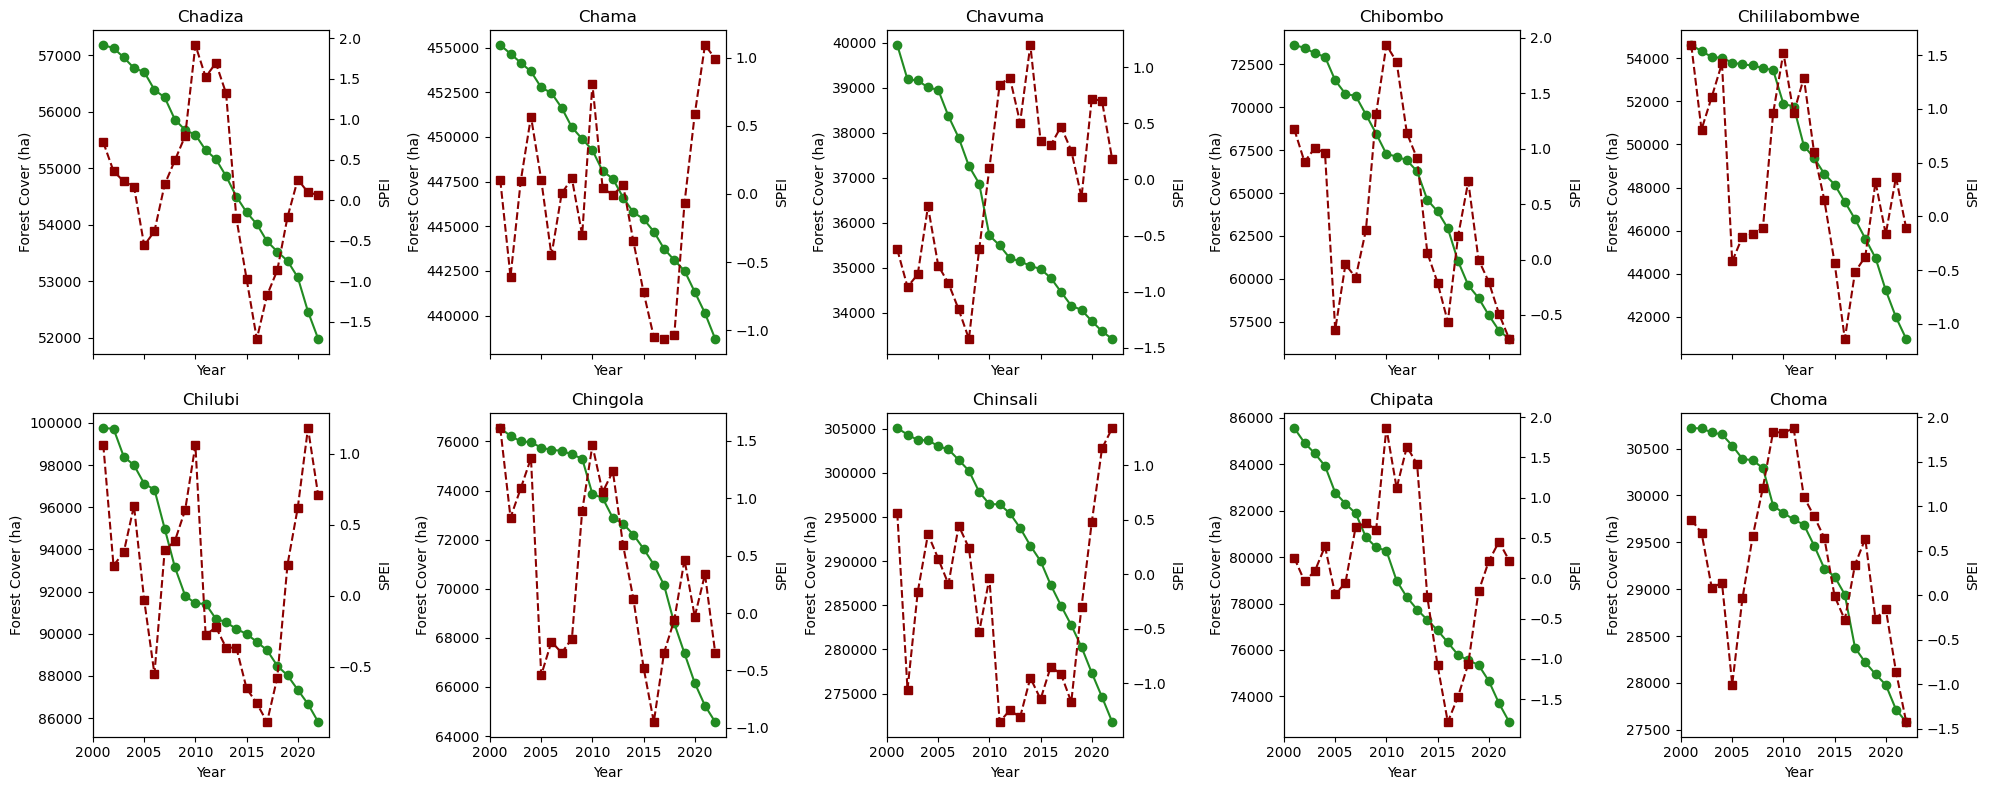

In [11]:
spei = pd.read_csv('./district_spei_average.csv', parse_dates=['date'])

# convert spei data to long format
spei_long = spei.melt(id_vars='date', var_name='district', value_name='spei')
spei_long['year'] = spei_long['date'].dt.year
spei_long['spei'] = spei_long['spei'].interpolate()

# aggregate SPEI to annual mean
spei_annual = spei_long.groupby(['district', 'year'])['spei'].mean().reset_index()

# merge dataframes
merged_df = pd.merge(spei_annual, df, on=['district', 'year'])

# get unique district names
districts = merged_df['district'].unique()

# create panel plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharex=True)
axes = axes.flatten()

for i, district in enumerate(districts[:10]):
    ax1 = axes[i]
    subset = merged_df[merged_df['district'] == district].sort_values('year')
    ax1.plot(subset['year'], subset['forest_cover_ha'], color='forestgreen', marker='o', label='Forest Cover')
    ax1.set_ylabel('Forest Cover (ha)')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(subset['year'], subset['spei'], color='darkred', marker='s', linestyle='--', label='SPEI')
    ax2.set_ylabel('SPEI')
    ax2.tick_params(axis='y')
    ax1.set_title(district)
    ax1.set_xlabel('Year')

plt.tight_layout()
plt.show()

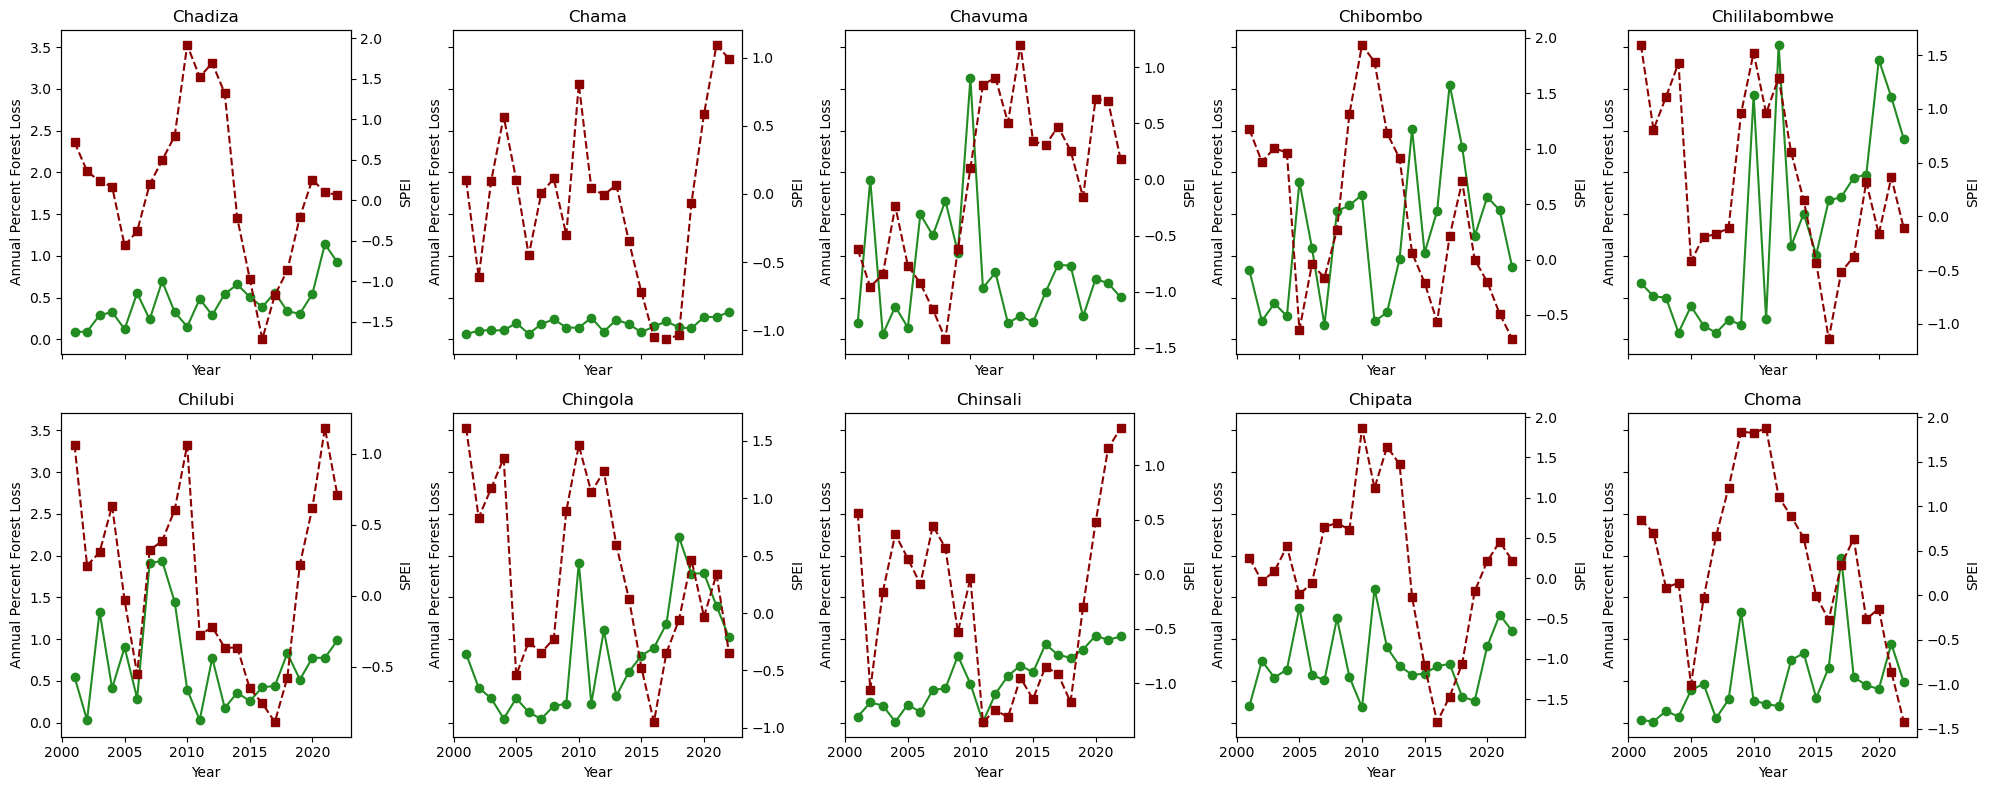

In [14]:
spei = pd.read_csv('./district_spei_average.csv', parse_dates=['date'])

# convert spei data to long format
spei_long = spei.melt(id_vars='date', var_name='district', value_name='spei')
spei_long['year'] = spei_long['date'].dt.year
spei_long['spei'] = spei_long['spei'].interpolate()

# aggregate SPEI to annual mean
spei_annual = spei_long.groupby(['district', 'year'])['spei'].mean().reset_index()

# merge dataframes
merged_df = pd.merge(spei_annual, df, on=['district', 'year'])

# get unique province names
districts = merged_df['district'].unique()

# create panel plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharex=True, sharey=True)
axes = axes.flatten()

for i, district in enumerate(districts[:10]):
    ax1 = axes[i]
    subset = merged_df[merged_df['district'] == district].sort_values('year')
    ax1.plot(subset['year'], subset['percent_loss_annual'], color='forestgreen', marker='o', label='Percent Forest Loss')
    ax1.set_ylabel('Annual Percent Forest Loss')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(subset['year'], subset['spei'], color='darkred', marker='s', linestyle='--', label='SPEI')
    ax2.set_ylabel('SPEI')
    ax2.tick_params(axis='y')
    ax1.set_title(district)
    ax1.set_xlabel('Year')

plt.tight_layout()
plt.show()

## Code graveyard 

In [ ]:
#year = 2018

#loss_in_year = loss_year.eq(year - 2000)

# mask to forested pixels in loss year
#loss_year_forest = loss_in_year.And(forest_2000)

# convert to area (square meters)
#loss_area = loss_year_forest.multiply(ee.Image.pixelArea())

# load Zambia boundary
#zambia = ee.FeatureCollection('FAO/GAUL/2015/level0') \
            #.filter(ee.Filter.eq('ADM0_NAME', 'Zambia'))

# get total loss area
#stats = loss_area.reduceRegion(
 #   reducer = ee.Reducer.sum(),
  #  geometry = zambia,
   # scale = 30,
    #maxPixels = 1e13
#)

# get result in hectares
#area_m2 = stats.getInfo().get('lossyear', 0)
#area_ha = area_m2 / 10000

#print(f"Forest loss in {year}: {area_ha:.2f} hectares")

In [ ]:
# create interactive map
Map = geemap.Map(center=[-13.1, 27.8], zoom=6)
    

# clip dataset to Zambia
#clipped_dataset = dataset.clip(zambia)

# visualization parameters
tree_cover_vis = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'palette': ['black', 'green']
}

loss_vis = {
    'min': 0,
    'max': 23,
    'palette': ['yellow', 'red']
}

# add base tree cover layer
Map.addLayer(clipped_dataset.select('treecover2000'), tree_cover_vis, 'Tree Cover 2000')

# loop through 'test years'
for year in range(2001, 2021, 5):
    code = year - 2000
    annual_loss = clipped_dataset.select('lossyear') \
                        .eq(code) \
                        .selfMask()
    Map.addLayer(annual_loss, {'palette': ['red']}, f'Tree Loss {year}')

Map